In [ ]:
!pip install numpy tabulate

In [ ]:
import importlib

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.plot_utils
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyDecisionTreeClassifier
from mysklearn.myclassifiers import MyKNeighborsClassifier
from mysklearn.myclassifiers import MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import numpy as np

# **Water Pollution & Disease: Predictive Analysis of Contaminant Levels and Health Risk**

**Team Members:** Charlie Serafin, Kayla Vo

**Project Name:** Predicting and Mapping Waterborne Risk

**Course:** CPSC 322-02, Fall 2025

This project used a synthetic “Water Pollution & Disease” dataset modeled on a Kaggle collection of country‑, region‑, and year‑level water and health data.

## **A. Introduction**

### 1. Dataset description
- Each row describes one setting with water‑quality measures (contaminant level, pH, turbidity, dissolved oxygen, nitrate, lead, bacteria) plus context such as country, region, year, access to clean water, sanitation coverage, healthcare access, and disease incidence.  
- The dataset is well structured but not perfectly balanced: the derived contamination label has many more “clean” than “contaminated” samples, while the derived risk label has equal numbers of low, medium, and high risk cases.

### 2. Classification tasks
- **Contamination detection:**  
  - Defined a binary label *Contaminated (yes/no)* using a rule that marks a sample as contaminated when at least two key contaminants (e.g., nitrate, lead, bacteria, turbidity) are unusually high for this dataset or when pH is far from neutral.  
  - Trained models using only numeric water‑quality features to predict this label.
- **Health risk prediction:**  
  - Defined a three‑level *Risk (low/medium/high)* label from a composite score combining disease incidence (diarrheal, cholera, typhoid) with a simple WASH vulnerability term based on low access to clean water and sanitation.  
  - Trained models using WASH, socio‑economic, climate, and contamination features to predict this risk category.

### 3. Methods and evaluation
- Trained three classifiers on each task:  
  - k‑nearest neighbors on min–max normalized numeric features.  
  - A custom decision tree using information gain.  
  - A custom random forest that aggregates multiple such trees built on bootstrap samples and random feature subsets.  
- Used stratified cross‑validation to evaluate performance, reporting accuracy, error rate, precision, recall, F1 for a chosen positive class, and confusion matrices.

### 4. Key findings
- **Contaminated label:**  
  - k‑nearest neighbors performed best overall, combining high accuracy with substantially higher recall and F1 for the minority “contaminated” class than the decision tree and random forest.  
  - The tree‑based models tended to predict the majority “clean” class, so they looked reasonable on accuracy but missed many truly contaminated samples.
- **Risk label:**  
  - All three methods achieved accuracy close to one third, which is expected given the three balanced risk classes.  
  - The decision tree and random forest provided better recall and F1 for the “high” risk group than k‑nearest neighbors, making them more suitable when correctly identifying high‑risk settings is more important than overall accuracy.

## **B. Data Analysis**

### 1. Information about the dataset

We will use the *Water Pollution & Disease* dataset from Kaggle, which contains country-, region-, and year-level measurements of water quality and related public health data. This dataset enables the analysis of the relationship between environmentals parameters and waterborne disease risks.

* Title: Water Pollution and Disease
* Source: Kaggle 
* Link: [Water Pollution & Disease](https://www.kaggle.com/datasets/khushikyad001/water-pollution-and-disease)
* Format: CSV file (Comma-Separated Values)
* Number of instances: 3000
* Contents: The dataset covers key factors and the socioeconomic variables below
    * Country: The country where data is collected
    * Region: The specific region within the country
    * Year: The year the data was recorded (2000-2025)
    * Water Source Type: Type of water source (e.g., River, Well, Tap, Lake, Spring, Pond)
    * Contaminant Level: The level of pollutants in parts per million ($ppm$)
    * pH Level: Acidity or alkalinity of the water (6.0-8.5)
    * Turbidity ($NTU$): Cloudiness of the water (measured in $NTU$ - Nephelometric Turbidity Units)
    * Dissolved Oxygen: Amount of oxygen dissolved in water, crucial for aquatic life ($mg/L$)
    * Nitrate Level: Concentration of nitrates in water, which can affect human health ($mg/L$)
    * Lead Concentration: Amount of lead present in micrograms per liter ($\mu g/L$)

### Brief Description of Attributes and Target Variable
Each record represents water quality metrics collected at a specific location and time.   
For our project:
* **Input (predictor) attributes:** All water quality measurements (e.g., pH, turbidity, nitrate, lead, etc.), location, year, and source type.   
* **Class Information (target):** We will predict a binary or multi-class classification 'risk' factor. For example, whether contaminant levels exceed safety guidelines, or what risk label should be assigned.
    * **Contaminated (Yes/No):** Classify of a water sample is "contaminated" based on project data (e.g., high lead or nitrate).
    * **Risk Level (Low/Medium/High):** Categorize each sample into risk groups, based on one or more contaminant levels.

In [ ]:
# Load csv into table
water_pollution_disease_table = MyPyTable().load_from_file("input_data/water_pollution_disease.csv")

In [ ]:
feature_cols = [
    "Contaminant Level (ppm)",
    "pH Level",
    "Turbidity (NTU)",
    "Dissolved Oxygen (mg/L)",
    "Nitrate Level (mg/L)",
    "Lead Concentration (µg/L)",
    "Bacteria Count (CFU/mL)",
    "Water Source Type",
    "Access to Clean Water (% of Population)",
    "Sanitation Coverage (% of Population)",
    "Healthcare Access Index (0-100)",
    "Population Density (people per km²)",
    "Urbanization Rate (%)",
    "Rainfall (mm per year)",
    "Temperature (°C)"
]

feature_table = water_pollution_disease_table.project_table(feature_cols)
X_all = feature_table.data  # rows of features only


### 2. Revelant summary statistics

In [ ]:
col_names = ["Contaminant Level (ppm)", "pH Level", "Turbidity (NTU)", "Dissolved Oxygen (mg/L)", "Nitrate Level (mg/L)", "Lead Concentration (µg/L)", "Bacteria Count (CFU/mL)"]
water_pollution_disease_table_summary_stats = feature_table.compute_summary_statistics(col_names)
water_pollution_disease_table_summary_stats.pretty_print()

attribute                    min      max       mid         avg    median
-------------------------  -----  -------  --------  ----------  --------
Contaminant Level (ppm)     0       10        5         4.95439     4.95
pH Level                    6        8.5      7.25      7.25585     7.28
Turbidity (NTU)             0        4.99     2.495     2.48002     2.46
Dissolved Oxygen (mg/L)     3       10        6.5       6.49285     6.49
Nitrate Level (mg/L)        0.05    49.99    25.02     25.0802     24.79
Lead Concentration (µg/L)   0       20       10        10.0479     10.065
Bacteria Count (CFU/mL)     0     4998     2499      2488.48     2469


### 3. Data Visualizations

#### a. Before creating labels

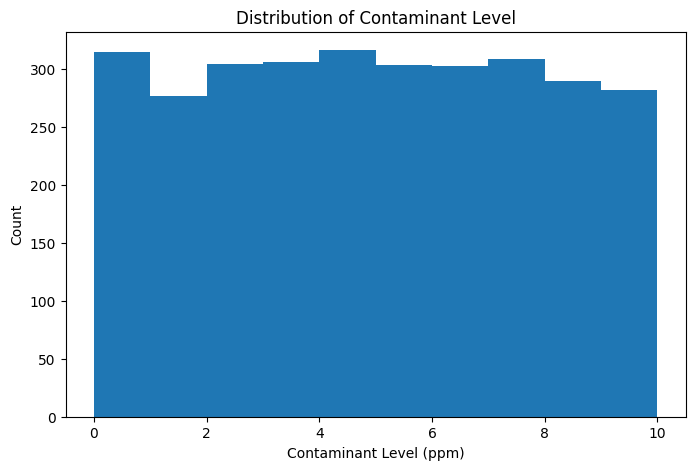

In [ ]:
num_bins = 10
contaminant_title = 'Distribution of Contaminant Level'
contaminant_column = feature_table.get_column(col_names[0])
plot_utils.plot_histogram(contaminant_title, contaminant_column, num_bins, "Contaminant Level (ppm)")

**Insights:** 
- Contaminant levels are fairly evenly spread over 0–10 ppm, suggesting the dataset samples a wide range of contamination intensities rather than being concentrated near a single level.

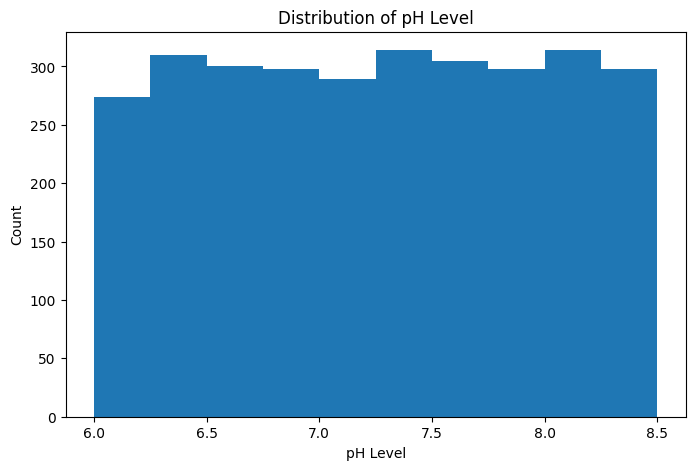

In [ ]:
pH_title = 'Distribution of pH Level'
pH_column = feature_table.get_column(col_names[1])
plot_utils.plot_histogram(pH_title, pH_column, num_bins, "pH Level")

**Insights:** 
- pH values are uniformly distributed between about 6.0 and 8.5, covering the typical guideline range for drinking water without strong skew toward either more acidic or more basic conditions.

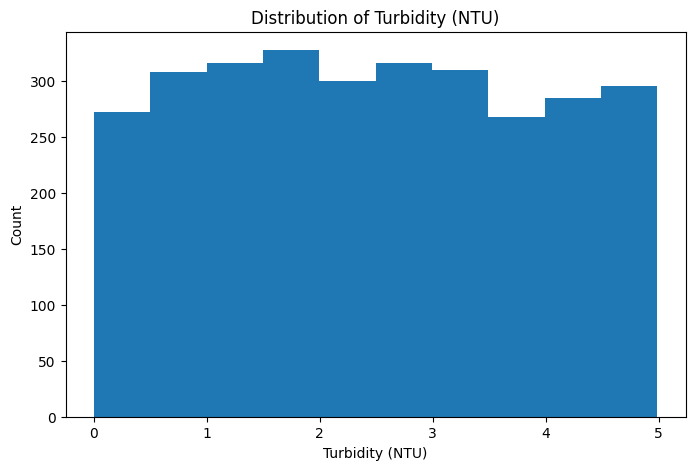

In [ ]:
turbidity_title = 'Distribution of Turbidity (NTU)'
turbidity_column = feature_table.get_column(col_names[2])
plot_utils.plot_histogram(turbidity_title, turbidity_column, num_bins, "Turbidity (NTU)")

**Insights:**
- Turbidity values are fairly evenly spread across the 0–5 NTU range, so the dataset contains both clear and turbid samples without a dominant turbidity band.

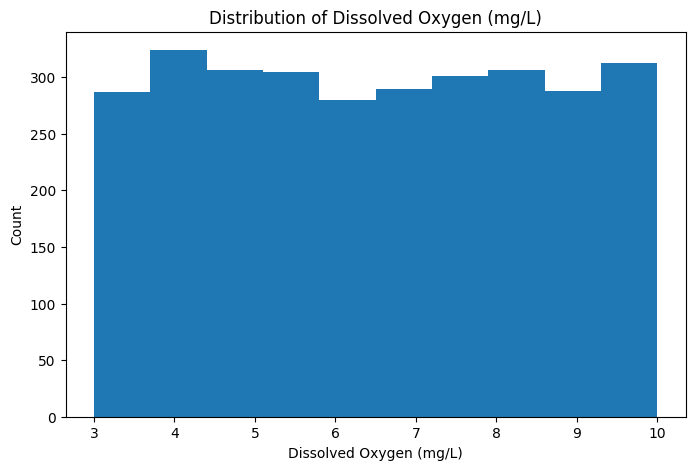

In [ ]:
dissolved_oxygen_title = 'Distribution of Dissolved Oxygen (mg/L)'
dissolved_oxygen_column = feature_table.get_column(col_names[3])
plot_utils.plot_histogram(dissolved_oxygen_title, dissolved_oxygen_column, num_bins, "Dissolved Oxygen (mg/L)")

**Insights:**
- Dissolved oxygen appears roughly uniformly distributed between about 3 and 10 mg/L, indicating that the dataset includes both relatively low‑oxygen and high‑oxygen waters in similar amounts.

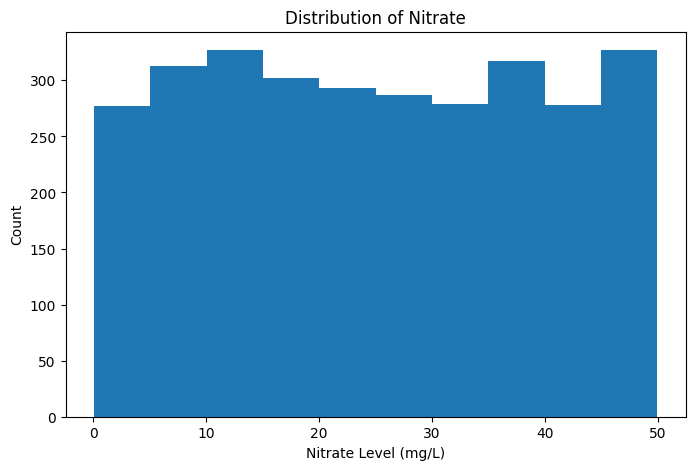

In [ ]:
nitrate_title = 'Distribution of Nitrate'
nitrate_column = feature_table.get_column(col_names[4])
plot_utils.plot_histogram(nitrate_title, nitrate_column, num_bins, "Nitrate Level (mg/L)")

**Insights:**
- The distribution of nitrate is roughly uniform across the 0–50 mg/L range, with similar counts in each bin; there is no obvious clustering at low or high levels in the marginal distribution.

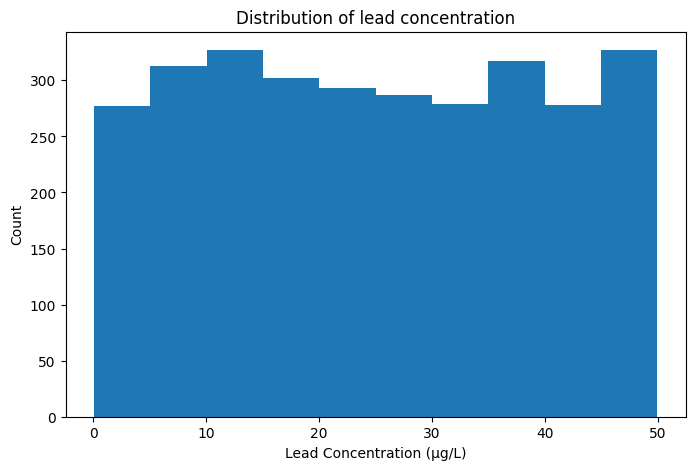

In [ ]:
lead_concentration_title = 'Distribution of lead concentration'
lead_concentration_column = feature_table.get_column(col_names[5])
plot_utils.plot_histogram(lead_concentration_title, nitrate_column, num_bins, "Lead Concentration (µg/L)")

**Insights:** This histogram shows that:
- The distribution of this feature is roughly uniform across the 0–50 range, with similar counts in each bin.
- There is no obvious clustering at low or high lead values in the marginal distribution.

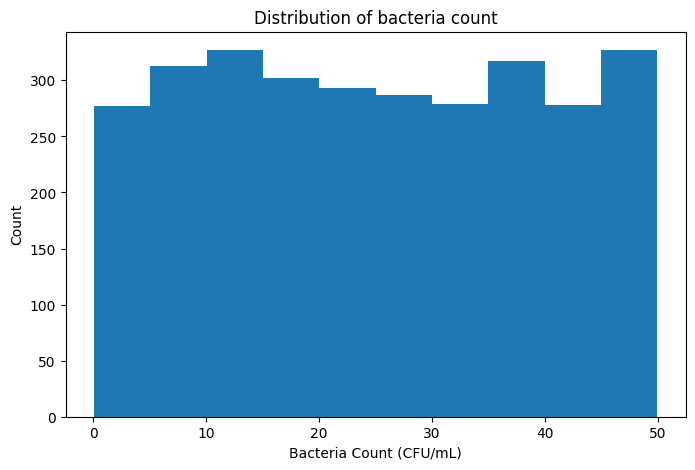

In [ ]:
bacteria_count_title = 'Distribution of bacteria count'
lead_concentration_column = feature_table.get_column(col_names[6])
plot_utils.plot_histogram(bacteria_count_title, nitrate_column, num_bins, "Bacteria Count (CFU/mL)")

**Insights:** This histogram shows that:       
- Bacteria counts are spread fairly evenly from low to high values (roughly uniform between 0 and 50 CFU/mL).
- There is no single dominant range or clear clustering in the marginal distribution; many samples have low counts, many have high counts.

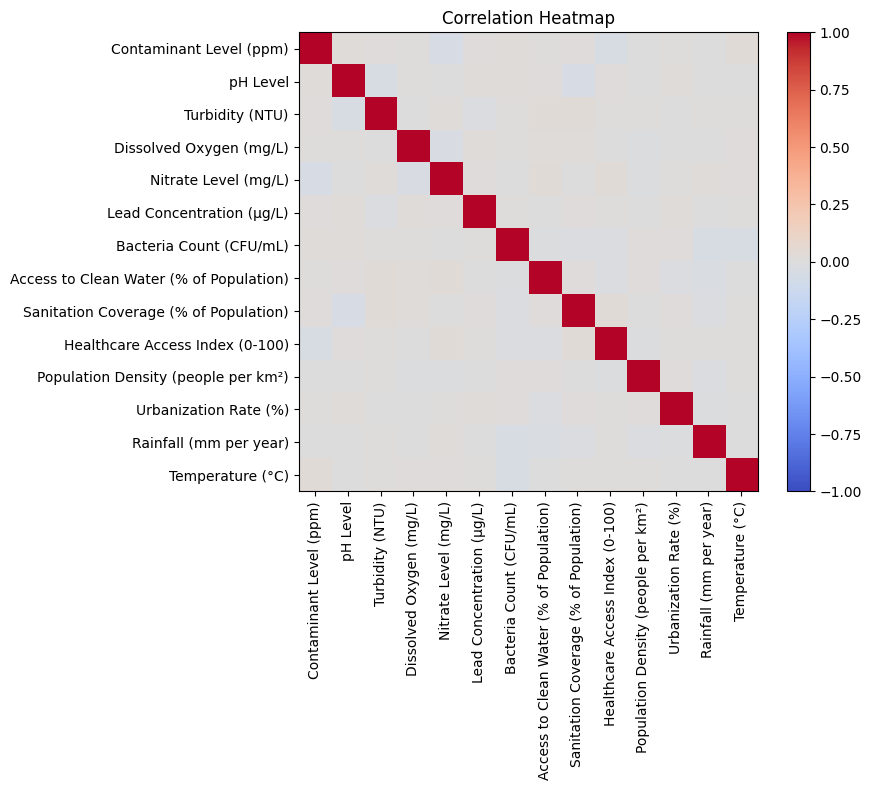

In [ ]:
plot_utils.plot_correlation_heatmap(feature_table)

**Insights:** The heatmap shows:    
- Features are not strongly correlated with each other (off‑diagonal values near 0).​  
- There is no obvious redundancy, so we do not need to drop any feature just because it’s highly correlated with another.

##### **Conclusion:**
- The pre‑label EDA shows that the chosen water‑quality and risk‑related features have diverse, roughly uniform distributions across their ranges.​
- There is no strong linear redundancy among these features, so none need to be removed solely due to high correlation with another feature.​
- With multicollinearity not a concern, the next step is to define Pollution and Risk labels using domain guidelines (e.g., EPA/WHO thresholds and simple risk‑score rules).

#### b. Feature Selection and Label Creation

- **Contaminated Label ("Yes"/"No"):** For this project, contamination is defined relative to the dataset rather than strict drinking‑water regulations. Each sample is checked against data‑driven cutoffs for key water‑quality indicators (nitrate, lead, bacteria, turbidity) and a wide acceptable band for pH. A sample is treated as polluted (“yes”) if two or more of these indicators are flagged as unusually high (above about the 80th percentile of this dataset) or the pH is far from neutral (below 6.0 or above 9.0). Otherwise, it is labeled as "no".  

- **Risk Label ("low"/"medium"/"high"):** Define a numeric risk score that combines disease burden and vulnerability, then bin it into 3 levels using tertiles. 
    - Risk Score:
        Use: Disease component = sum of incidences    
            - Diarrheal Cases per 100,000 people      
            - Cholera Cases per 100,000 people      
            - Typhoid Cases per 100,000 people      
             Vulnerability component = lack of WASH coverage   
            = $ (100 - \text{Access to Clean Water} \%) + (100 - \text{Sanitation Coverage} \%) $

In [ ]:
header = water_pollution_disease_table.column_names
bact_col = water_pollution_disease_table.get_column("Bacteria Count (CFU/mL)", include_missing_values=False)

nitrate_vals = [float(v) for v in water_pollution_disease_table.get_column("Nitrate Level (mg/L)", False)]
lead_vals    = [float(v) for v in water_pollution_disease_table.get_column("Lead Concentration (µg/L)", False)]
bact_vals    = [float(v) for v in water_pollution_disease_table.get_column("Bacteria Count (CFU/mL)", False)]
turb_vals    = [float(v) for v in water_pollution_disease_table.get_column("Turbidity (NTU)", False)]

nitrate_hi = np.percentile(nitrate_vals, 80)
lead_hi    = np.percentile(lead_vals, 80)
bact_hi    = np.percentile(bact_vals, 80)
turb_hi    = np.percentile(turb_vals, 80)

contamination_labels = [myutils.make_pollution_label(row, header, nitrate_hi, lead_hi, bact_hi, turb_hi) for row in water_pollution_disease_table.data]

myutils.add_column(water_pollution_disease_table, "Contaminated", contamination_labels)

scores = [myutils.make_risk_score(row, header) for row in water_pollution_disease_table.data]

sorted_scores = sorted(scores)
n = len(sorted_scores)
t1 = sorted_scores[int(n/3)]
t2 = sorted_scores[int(2*n/3)]

risk_labels = [myutils.score_to_risk_label(s, t1, t2) for s in scores]
myutils.add_column(water_pollution_disease_table, "Risk", risk_labels)

Country     Region      Year  Water Source Type      Contaminant Level (ppm)    pH Level    Turbidity (NTU)    Dissolved Oxygen (mg/L)    Nitrate Level (mg/L)    Lead Concentration (µg/L)    Bacteria Count (CFU/mL)  Water Treatment Method      Access to Clean Water (% of Population)    Diarrheal Cases per 100,000 people    Cholera Cases per 100,000 people    Typhoid Cases per 100,000 people    Infant Mortality Rate (per 1,000 live births)    GDP per Capita (USD)    Healthcare Access Index (0-100)    Urbanization Rate (%)    Sanitation Coverage (% of Population)    Rainfall (mm per year)    Temperature (°C)    Population Density (people per km²)  Contaminated    Risk
----------  --------  ------  -------------------  -------------------------  ----------  -----------------  -------------------------  ----------------------  ---------------------------  -------------------------  ------------------------  -----------------------------------------  ------------------------------------  --

In [ ]:
contaminated_features = ['Water Source Type', 'Contaminant Level (ppm)', 'pH Level', 'Turbidity (NTU)', 'Dissolved Oxygen (mg/L)', 'Nitrate Level (mg/L)', 'Lead Concentration (µg/L)', 'Bacteria Count (CFU/mL)', 'Contaminated']
contaminated_table = water_pollution_disease_table.project_table(contaminated_features)

risk_features = ['Country', 'Region', 'Year', 'Access to Clean Water (% of Population)', 'Sanitation Coverage (% of Population)', 'Healthcare Access Index (0-100)', 'Population Density (people per km²)', 'Urbanization Rate (%)', 'Rainfall (mm per year)', 'Temperature (°C)', 'Contaminated', 'Risk']
risk_table = water_pollution_disease_table.project_table(risk_features)

##### **For contaminated label**

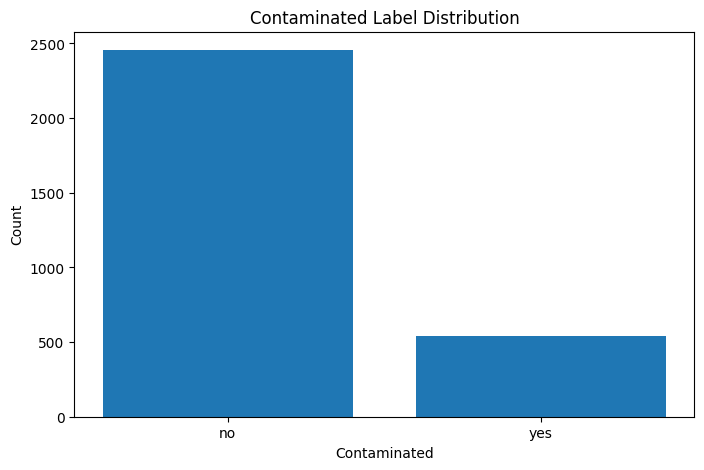

In [ ]:
contam_col = water_pollution_disease_table.get_column("Contaminated", False)
contam_counts = myutils.value_counts(contam_col)
plot_utils.plot_frequency_diagrams(
    title="Contaminated Label Distribution",
    counts=contam_counts,
    xlabel="Contaminated"
)

**Insights:**    
For ```Contaminated```, the classes are clearly imbalanced: about 2,450 “no” vs 550 “yes”, so only roughly 18–20% of samples are labeled contaminated. This means a naive model that always predicts “no” would already get around 80% accuracy, so we will have to report metrics like precision, recall, and use stratified splits or class‑balanced evaluation to show value beyond that baseline.

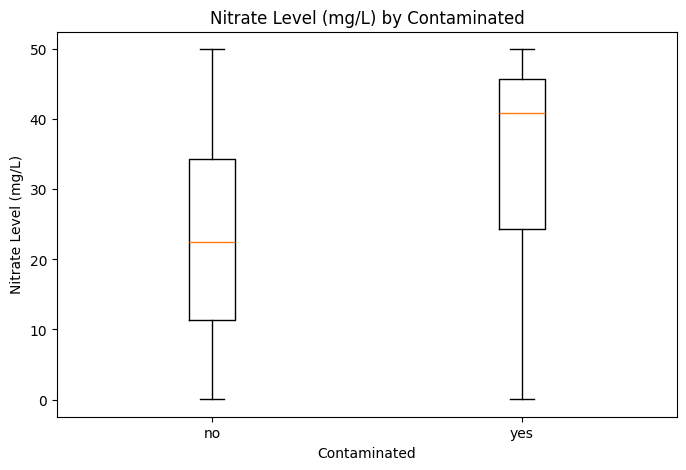

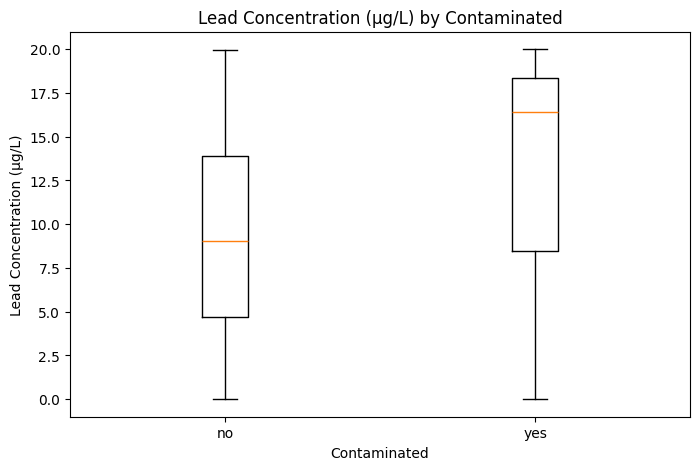

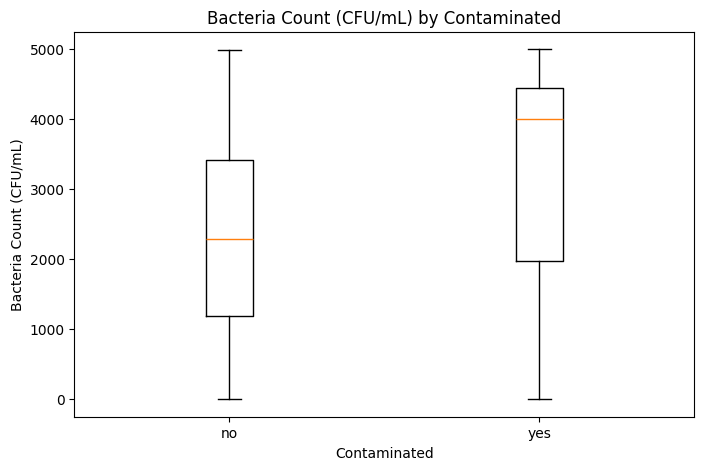

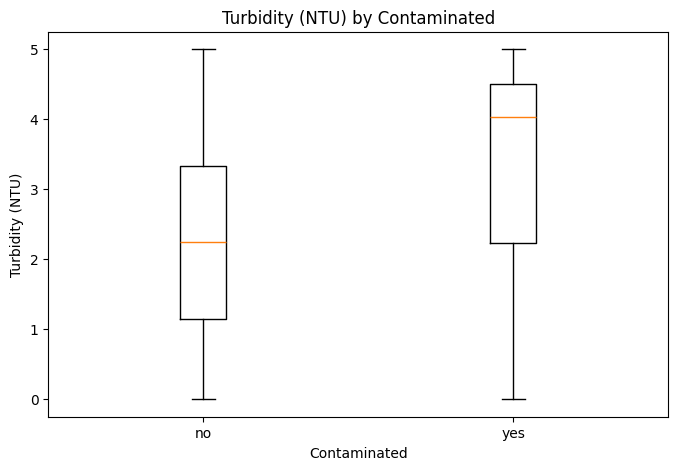

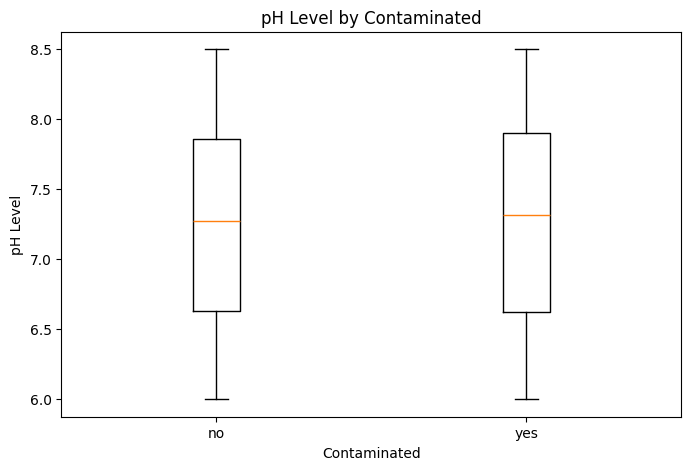

In [ ]:
for col in [
    "Nitrate Level (mg/L)",
    "Lead Concentration (µg/L)",
    "Bacteria Count (CFU/mL)",
    "Turbidity (NTU)",
    "pH Level"
]:
    plot_utils.boxplot_by_label(water_pollution_disease_table, col, "Contaminated")

**Insights:** These boxplots show that the contamination label is doing what we intended and that pH contributes less than the other indicators.
- For nitrate, lead, bacteria, and turbidity, the “yes” box is clearly shifted higher than the “no” box, and the medians for contaminated samples are above those for non‑contaminated samples. This supports that contaminated sites tend to have systematically higher levels on all four indicators, not just random noise.​
- The spreads overlap but “yes” tends to occupy the upper part of each variable’s range, which matches our rule of flagging rows with multiple unusually high values.​
- For pH, the distributions for “yes” and “no” are very similar, with overlapping medians and ranges. That suggests pH is less discriminative for our contamination label in this dataset, probably because most samples fall within our relatively wide acceptable pH band.

##### **For risk label**

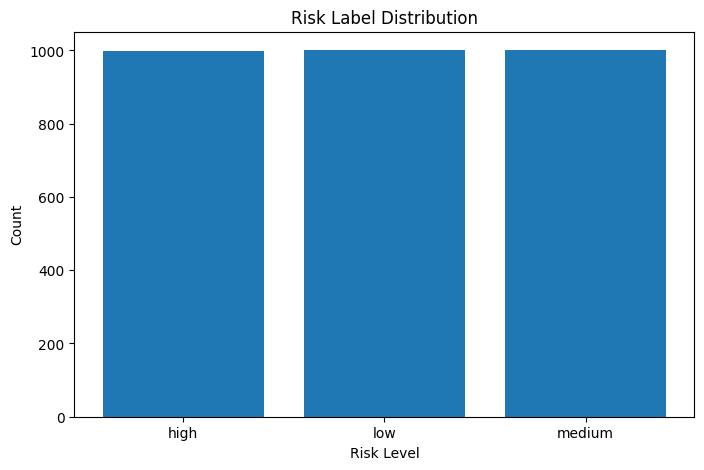

In [ ]:
risk_col = water_pollution_disease_table.get_column("Risk", False)
risk_counts = myutils.value_counts(risk_col)
plot_utils.plot_frequency_diagrams(
    title="Risk Label Distribution",
    counts=risk_counts,
    xlabel="Risk Level"
)

**Insights:**         
For ```Risk```, the classes are perfectly balanced at about 1,000 each for “low”, “medium”, and “high”, so a trivial baseline is 33% accuracy. This is ideal for our risk classifier, because models are not biased toward any one class and performance comparisons (accuracy, per‑class recall) will be more informative. 

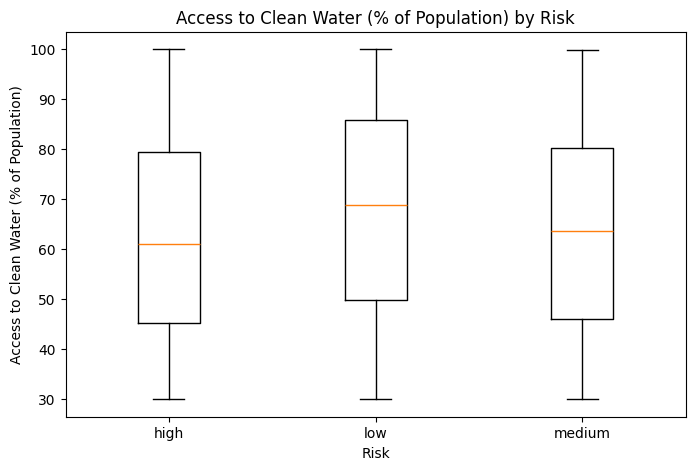

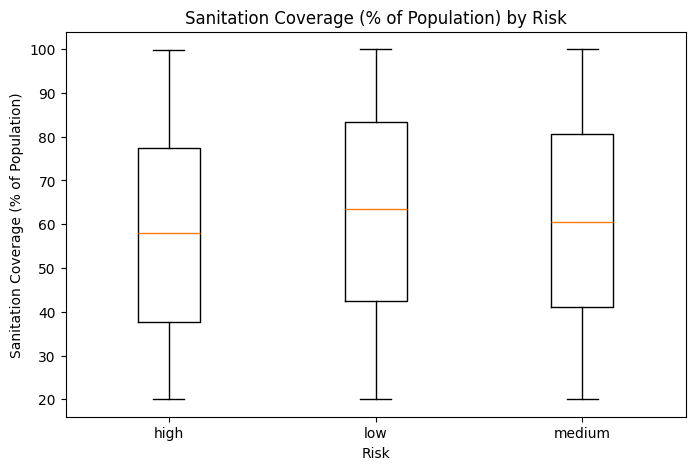

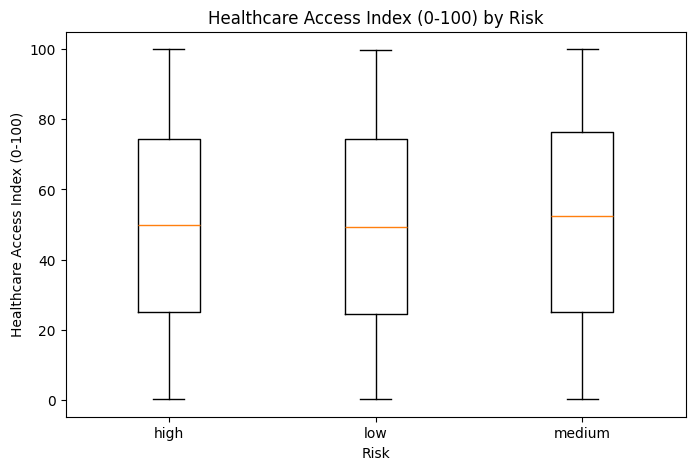

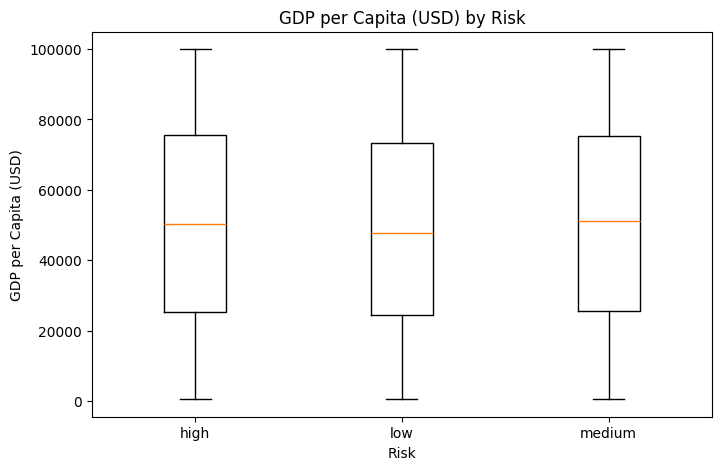

In [ ]:
for col in [
    "Access to Clean Water (% of Population)",
    "Sanitation Coverage (% of Population)",
    "Healthcare Access Index (0-100)",
    "GDP per Capita (USD)"
]:
    plot_utils.boxplot_by_label(water_pollution_disease_table, col, "Risk")

**Insights:** The boxplots show that risk is not driven by any single context variable
- Access to clean water, sanitation coverage, healthcare index, and GDP all have very similar, overlapping distributions across low, medium, and high risk.​
- This means our Risk label reflects a composite of disease burden and WASH factors rather than simply “low access = high risk” or “low GDP = high risk”.

## **C. Classification Results**

### 1. K-Nearest Neighbors (KNN)

- Used a standard k‑nearest neighbors classifier with distance computed on numeric features after min–max normalization (normalization recomputed from the training fold and applied to the corresponding test fold).
- Set the neighborhood size to k = 10, so each prediction is based on the majority class among the 10 closest training examples.

#### a. Contaminated Label

In [ ]:
contam_numeric_feats = [
    'Contaminant Level (ppm)',
    'pH Level',
    'Turbidity (NTU)',
    'Dissolved Oxygen (mg/L)',
    'Nitrate Level (mg/L)',
    'Lead Concentration (µg/L)',
    'Bacteria Count (CFU/mL)'
]

contam_feat_idxs = [contaminated_table.column_names.index(col)
                    for col in contam_numeric_feats]
contam_target_idx = contaminated_table.column_names.index("Contaminated")

X_contam = [[row[i] for i in contam_feat_idxs] for row in contaminated_table.data]
y_contam = [row[contam_target_idx] for row in contaminated_table.data]

contam_knn_results = myutils.evaluate_knn_cv(
    X_contam,
    y_contam,
    feature_names=contam_numeric_feats,
    positive_label="yes",
    n_splits=10,
    n_neighbors=10,
    stratify=True,
    random_state=0,
    shuffle=True
)

print("===========================================")
print("Predictive Accuracy – Contaminated (kNN)")
print("===========================================\n")
print("Stratified 10-Fold Cross Validation")
acc  = contam_knn_results["accuracy"]
err  = contam_knn_results["error_rate"]
prec = contam_knn_results["precision"]
rec  = contam_knn_results["recall"]
f1   = contam_knn_results["f1"]
print(f"kNN: accuracy = {acc:.2f}, error rate = {err:.2f}")
print(f"Precision (pos=yes) = {prec:.2f}")
print(f"Recall    (pos=yes) = {rec:.2f}")
print(f"F1        (pos=yes) = {f1:.2f}")
print("-------------------------------------------")
print("===========================================")
print("Confusion Matrix")
print("===========================================")
myutils.print_confusion_table(
    ["label"],
    contam_knn_results["confusion_matrix"],
    ["yes", "no"],
    "kNN (Stratified 10-Fold Cross Validation Results):"
)


Predictive Accuracy – Contaminated (kNN)

Stratified 10-Fold Cross Validation
kNN: accuracy = 0.89, error rate = 0.11
Precision (pos=yes) = 0.87
Recall    (pos=yes) = 0.47
F1        (pos=yes) = 0.61
-------------------------------------------
Confusion Matrix
kNN (Stratified 10-Fold Cross Validation Results):
label      yes    no    Total    Recognition (%)
yes        254   290      544                 47
no          39  2417     2456                 98



#### b. Risk Label

In [ ]:
risk_numeric_feats = [
    'Access to Clean Water (% of Population)',
    'Sanitation Coverage (% of Population)',
    'Healthcare Access Index (0-100)',
    'Population Density (people per km²)',
    'Urbanization Rate (%)',
    'Rainfall (mm per year)',
    'Temperature (°C)',
]

risk_feat_idxs = [risk_table.column_names.index(col)
                  for col in risk_numeric_feats]
risk_target_idx = risk_table.column_names.index("Risk")

X_risk = [[row[i] for i in risk_feat_idxs] for row in risk_table.data]
y_risk = [row[risk_target_idx] for row in risk_table.data]

risk_knn_results = myutils.evaluate_knn_cv(
    X_risk,
    y_risk,
    feature_names=risk_numeric_feats,
    positive_label="high",
    n_splits=10,
    n_neighbors=10,
    stratify=True,
    random_state=0,
    shuffle=True
)

print("===========================================")
print("Predictive Accuracy – Risk (kNN)")
print("===========================================\n")
print("Stratified 10-Fold Cross Validation")
acc  = risk_knn_results["accuracy"]
err  = risk_knn_results["error_rate"]
prec = risk_knn_results["precision"]
rec  = risk_knn_results["recall"]
f1   = risk_knn_results["f1"]
print(f"kNN: accuracy = {acc:.2f}, error rate = {err:.2f}")
print(f"Precision (pos=high) = {prec:.2f}")
print(f"Recall    (pos=high) = {rec:.2f}")
print(f"F1        (pos=high) = {f1:.2f}")
print("-------------------------------------------")
print("===========================================")
print("Confusion Matrix")
print("===========================================")
myutils.print_confusion_table(
    ["label"],
    risk_knn_results["confusion_matrix"],
    ["high", "low", "medium"],
    "kNN (Stratified 10-Fold Cross Validation Results):"
)

Predictive Accuracy – Risk (kNN)

Stratified 10-Fold Cross Validation
kNN: accuracy = 0.33, error rate = 0.67
Precision (pos=high) = 0.32
Recall    (pos=high) = 0.32
F1        (pos=high) = 0.32
-------------------------------------------
Confusion Matrix
kNN (Stratified 10-Fold Cross Validation Results):
label      high    low    medium    Total    Recognition (%)
high        319    341       339      999                 32
low         343    328       330     1001                 33
medium      344    314       342     1000                 34



### 2. Decision Trees

- Implemented a custom, unpruned decision tree learner that uses information gain (entropy reduction) to choose the best splitting attribute at each node.
- Trained the tree on the training fold and then used it to predict labels by traversing from the root to a leaf for each test instance.
- Used stratified 10‑fold cross‑validation to ensure each fold preserved the class distribution.

#### a. Contaminated Label

In [ ]:
contam_results = myutils.evaluate_decision_tree_cv(
    X_contam,
    y_contam,
    feature_names=contam_numeric_feats,
    positive_label="yes",
    n_splits=10,
    stratify=True,
    random_state=0,
    shuffle=True
)

print("===========================================")
print("Predictive Accuracy – Contaminated")
print("===========================================\n")
print("Stratified 10-Fold Cross Validation")
acc  = contam_results["accuracy"]
err  = contam_results["error_rate"]
prec = contam_results["precision"]
rec  = contam_results["recall"]
f1   = contam_results["f1"]
print(f"Decision Tree: accuracy = {acc:.2f}, error rate = {err:.2f}")
print(f"Precision (pos=yes) = {prec:.2f}")
print(f"Recall    (pos=yes) = {rec:.2f}")
print(f"F1        (pos=yes) = {f1:.2f}")
print("-------------------------------------------")
print("===========================================")
print("Confusion Matrix")
print("===========================================")
myutils.print_confusion_table(
    ["label"],
    contam_results["confusion_matrix"],
    ["yes", "no"],
    "Decision Tree (Stratified 10-Fold Cross Validation Results):"
)


Predictive Accuracy – Contaminated

Stratified 10-Fold Cross Validation
Decision Tree: accuracy = 0.75, error rate = 0.25
Precision (pos=yes) = 0.21
Recall    (pos=yes) = 0.14
F1        (pos=yes) = 0.17
-------------------------------------------
Confusion Matrix
Decision Tree (Stratified 10-Fold Cross Validation Results):
label      yes    no    Total    Recognition (%)
yes         78   466      544                 14
no         288  2168     2456                 88



#### b. Risk Label

In [ ]:
risk_results = myutils.evaluate_decision_tree_cv(
    X_risk,
    y_risk,
    feature_names=risk_numeric_feats,
    positive_label="high",
    n_splits=10,
    stratify=True,
    random_state=0,
    shuffle=True
)

print("===========================================")
print("Predictive Accuracy – Risk")
print("===========================================\n")
print("Stratified 10-Fold Cross Validation")
acc  = risk_results["accuracy"]
err  = risk_results["error_rate"]
prec = risk_results["precision"]
rec  = risk_results["recall"]
f1   = risk_results["f1"]
print(f"Decision Tree: accuracy = {acc:.2f}, error rate = {err:.2f}")
print(f"Precision (pos=high) = {prec:.2f}")
print(f"Recall    (pos=high) = {rec:.2f}")
print(f"F1        (pos=high) = {f1:.2f}")
print("-------------------------------------------")
print("===========================================")
print("Confusion Matrix")
print("===========================================")
myutils.print_confusion_table(
    ["label"],
    risk_results["confusion_matrix"],
    ["high", "low", "medium"],
    "Decision Tree (Stratified 10-Fold Cross Validation Results):"
)

Predictive Accuracy – Risk

Stratified 10-Fold Cross Validation
Decision Tree: accuracy = 0.33, error rate = 0.67
Precision (pos=high) = 0.33
Recall    (pos=high) = 0.84
F1        (pos=high) = 0.47
-------------------------------------------
Confusion Matrix
Decision Tree (Stratified 10-Fold Cross Validation Results):
label      high    low    medium    Total    Recognition (%)
high        841     72        86      999                 84
low         854     83        64     1001                  8
medium      865     68        67     1000                  7



### 3. Custom Random Forest

- Built a custom random forest as an ensemble of decision trees, each trained on a bootstrap sample of the training data with a random subset of features for each tree.
- Used 20 trees in the forest (20 trees for faster cross‑validation) and a limited number of features per tree (such as $\sqrt{d}$ or a small fixed number) to introduce diversity among trees.
- For each test instance, collected the predictions from all trees and used majority voting to produce the final class label, again evaluated with stratified k‑fold cross‑validation.

#### a. Contaminated Label

In [ ]:
rf_contam_results = myutils.evaluate_random_forest_cv(
    X_contam,
    y_contam,
    feature_names=contam_numeric_feats,
    positive_label="yes",
    n_splits=10,
    n_trees=20,
    max_features=None,   # or an int if you want
    stratify=True,
    random_state=0,
    shuffle=True
)

print("===========================================")
print("Predictive Accuracy – Contaminated (RF)")
print("===========================================\n")
print("Stratified 10-Fold Cross Validation")
acc  = rf_contam_results["accuracy"]
err  = rf_contam_results["error_rate"]
prec = rf_contam_results["precision"]
rec  = rf_contam_results["recall"]
f1   = rf_contam_results["f1"]
print(f"Random Forest: accuracy = {acc:.2f}, error rate = {err:.2f}")
print(f"Precision (pos=yes) = {prec:.2f}")
print(f"Recall    (pos=yes) = {rec:.2f}")
print(f"F1        (pos=yes) = {f1:.2f}")
print("-------------------------------------------")
print("===========================================")
print("Confusion Matrix")
print("===========================================")
myutils.print_confusion_table(
    ["label"],
    rf_contam_results["confusion_matrix"],
    ["yes", "no"],
    "Random Forest (Stratified 10-Fold Cross Validation Results):"
)

Predictive Accuracy – Contaminated (RF)

Stratified 10-Fold Cross Validation
Random Forest: accuracy = 0.82, error rate = 0.18
Precision (pos=yes) = 0.37
Recall    (pos=yes) = 0.01
F1        (pos=yes) = 0.02
-------------------------------------------
Confusion Matrix
Random Forest (Stratified 10-Fold Cross Validation Results):
label      yes    no    Total    Recognition (%)
yes          7   537      544                  1
no          12  2444     2456                100



#### b. Risk Label

In [ ]:
rf_risk_results = myutils.evaluate_random_forest_cv(
    X_risk,
    y_risk,
    feature_names=risk_numeric_feats,
    positive_label="high",
    n_splits=10,
    n_trees=20,
    max_features=None,
    stratify=True,
    random_state=0,
    shuffle=True
)

print("===========================================")
print("Predictive Accuracy – Risk (RF)")
print("===========================================\n")
print("Stratified 10-Fold Cross Validation")
acc  = rf_risk_results["accuracy"]
err  = rf_risk_results["error_rate"]
prec = rf_risk_results["precision"]
rec  = rf_risk_results["recall"]
f1   = rf_risk_results["f1"]
print(f"Random Forest: accuracy = {acc:.2f}, error rate = {err:.2f}")
print(f"Precision (pos=high) = {prec:.2f}")
print(f"Recall    (pos=high) = {rec:.2f}")
print(f"F1        (pos=high) = {f1:.2f}")
print("-------------------------------------------")
print("===========================================")
print("Confusion Matrix")
print("===========================================")
myutils.print_confusion_table(
    ["label"],
    rf_risk_results["confusion_matrix"],
    ["high", "low", "medium"],
    "Random Forest (Stratified 10-Fold Cross Validation Results):"
)

Predictive Accuracy – Risk (RF)

Stratified 10-Fold Cross Validation
Random Forest: accuracy = 0.34, error rate = 0.66
Precision (pos=high) = 0.33
Recall    (pos=high) = 0.71
F1        (pos=high) = 0.45
-------------------------------------------
Confusion Matrix
Random Forest (Stratified 10-Fold Cross Validation Results):
label      high    low    medium    Total    Recognition (%)
high        713    243        43      999                 71
low         702    262        37     1001                 26
medium      721    248        31     1000                  3



### 4. Comparison
Overall, kNN is the best of the three, mainly because it handles the strong class imbalance on the Contaminated label better than the trees and forest.

#### Contaminated label

- **kNN:** accuracy 0.89, precision 0.87, recall 0.47, F1 0.61. It correctly finds about half of the contaminated sites while keeping few false positives, which is strong given only ~18–20% of rows are “yes”.  
- **Decision tree:** lower accuracy (0.75) and very low recall (0.14, F1 0.17), so it misses most contaminated cases.  
- **Random forest:** accuracy 0.82 but almost never predicts “yes” (recall 0.01, F1 0.02); it collapses to the majority “no” class.  

For contamination detection, **kNN is clearly best** because it balances overall accuracy with much higher recall and F1 on the minority “yes” class.

#### Risk label

- All three methods have similar overall accuracy around 0.33–0.34, which is close to the 1/3 baseline for three balanced classes.  
- For the high‑risk class, the decision tree and random forest give higher recall (0.84 and 0.71) but modest precision (~0.33), while kNN has lower recall (0.32) and F1 (0.32).  

For risk, **the decision tree is slightly preferable** if the priority is catching high‑risk areas (highest recall and F1 among the three), while kNN offers no accuracy advantage and weaker high‑risk detection.

## **D. Conclusion**

### 1. Dataset and Challenges
- Included water‑quality features (contaminant level, pH, turbidity, dissolved oxygen, nitrate, lead, bacteria) plus context (access to clean water, sanitation, healthcare index, GDP, population density, rainfall, temperature, country/region/year).  
- Contamination and Risk were derived labels rather than directly observed outcomes, based on water indicators and disease/WASH information.  
- The main challenge was class imbalance: “Contaminated” had far fewer “yes” cases than “no”, while “Risk” was perfectly balanced across low/medium/high, affecting how accuracy should be interpreted.

### 2. Classification Approach
- Defined a contamination rule: label a sample as contaminated when at least two key water‑quality indicators are unusually high (relative to this dataset) or when pH is far from neutral, then add this as a binary target column.  
- Constructed two working tables: a contamination table with only water‑quality features and a risk table with WASH, socio‑economic, climate, and contamination features.  
- Trained three classifiers for each task: k‑nearest neighbors on min–max normalized numeric features, a custom decision tree using information gain, and a custom random forest built from bootstrap samples and random feature subsets.  
- Evaluated all models with stratified k‑fold cross‑validation, reporting accuracy, error rate, precision, recall, F1 for a chosen positive class, and confusion matrices.

### 3. Classifier Performance
- For the Contaminated label, k‑nearest neighbors performed best, achieving high overall accuracy and substantially higher recall and F1 for the minority “yes” class than the decision tree or random forest.  
- The decision tree achieved moderate accuracy but low recall and F1 for contamination, indicating that it frequently predicted the majority “no” class.  
- The random forest reached good accuracy but almost never predicted “yes”, leading to extremely low recall and F1 for contamination despite looking strong on overall error rate.  
- For the Risk label, all three models achieved accuracy around one‑third, consistent with three balanced classes; decision tree and random forest showed higher recall and F1 for the “high” risk class than k‑nearest neighbors, so they were somewhat better at identifying high‑risk regions even though overall accuracy remained limited.

### 4. Opportunities for Improvement
- Apply imbalance‑aware strategies (e.g., resampling or class‑weighted training) to improve recall and F1 on the contaminated class without overly sacrificing accuracy.  
- Refine feature engineering and label construction, such as experimenting with different percentile thresholds or weighting specific contaminants and WASH variables more heavily in the contamination and risk definitions.  
- Perform systematic hyperparameter tuning for all models: vary k in k‑nearest neighbors, control depth and pruning for decision trees, and adjust number of trees and max‑features for the random forest.  
- Incorporate encoded categorical variables (country, region, water source type) so models can exploit spatial and infrastructural patterns that may help distinguish risk levels and contamination status.

## **E. Acknowledgements**

- This project used a dataset from Kaggle; all preprocessing, labeling, and modeling code was developed specifically for this assignment, with no external code copied.
- An AI assistant was used in the project to help with interpreting some results, brainstorming and polishing written explanations, but all final design and code implementations were made by the project team.
- The idea of defining “vulnerability” as the lack of WASH coverage (e.g., using terms like 
$ (100 - \text{Access to Clean Water} \%) + (100 - \text{Sanitation Coverage} \%) $) was inspired by common public‑health practice in WASH and disease‑burden studies, where insufficient access to safe water and sanitation is treated as a key vulnerability component in composite risk indices.
- Contribution:
    - Charlie Serafin:
        - Provide the dataset
        - Developed the first draft of the presentation slides and code
        - Created repository on Github
    - Kayla Vo:
        - Completed Project Porposal
        - Designed all final source code
        - Wrote technical report
        - Made final presentation slides
        - Performed interpretation and analysis